# Data Preprocessing
## Load Data And Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
os.makedirs("data", mode=0o777, exist_ok=True)

df=pd.read_csv('ai4i2020.csv')
print(f"shape of data {df.shape}")
df.info()

shape of data (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dt

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
print("Unique values in each column:")
for col in df.columns:
    unique_values = df[col].unique()
    if len(unique_values) < 10:
        print(f"{col:30} \t{unique_values}")
    else:   
        print(f"{col:30} \t{len(df[col].unique())} values")

Unique values in each column:
UDI                            	10000 values
Product ID                     	10000 values
Type                           	['M' 'L' 'H']
Air temperature [K]            	93 values
Process temperature [K]        	82 values
Rotational speed [rpm]         	941 values
Torque [Nm]                    	577 values
Tool wear [min]                	246 values
Machine failure                	[0 1]
TWF                            	[0 1]
HDF                            	[0 1]
PWF                            	[0 1]
OSF                            	[0 1]
RNF                            	[0 1]


From the unique values analysis above, we know that UDI and Product ID can be removed.

Both columns has 1000 unique values and we have 1000 rows of samples. 

Hence, the values are unique for each sample.

## Remove Row Unique ID and Product ID

In [5]:
df.drop(columns=['UDI', 'Product ID'], inplace=True)
print(f"shape of data after dropping columns {df.shape}")

shape of data after dropping columns (10000, 12)


## Change Feature Names to Remove Brackets

Some classifiers like XGBoost does not like features with special symbols and throws exception

ValueError('feature_names may not contain [, ] or <')

In [6]:
df.columns = [col.replace("[","(").replace("]",")") for col in df.columns.values]
print("DF columns after clean up", df.columns)


DF columns after clean up Index(['Type', 'Air temperature (K)', 'Process temperature (K)',
       'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


## Max and Min For Numeric Values

In [7]:
exclude = ['Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df.drop(exclude, axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature (K),10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature (K),10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed (rpm),10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque (Nm),10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear (min),10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


## Convert Type From Category To Numeric

In [8]:
df['Type'] = df['Type'].astype('category')
type_mapping = {'L': 0, 'M': 1, 'H': 2}
df['Type'] = df['Type'].map(type_mapping).astype('int')
print(" Type  Unique Values after encoding: ", df['Type'].unique())

 Type  Unique Values after encoding:  [1 0 2]


## Check for Duplicates And Missing Data

In [9]:
print("number of duplicated rows : ", df.duplicated().sum())
print("number of null values : ", df.isnull().sum().sum())

number of duplicated rows :  0
number of null values :  0


Our data does not seem to have any duplicate or missing data.
This is given the data is synthetic data created through simulation.

## Check Our Target and Label For Mismatch

We want to check whether there is any machine failures that are not attributed to the 5 known failures

This should be changed to non failure as RNF already handled random failure.

Hence, this is data error and should have been a pass

In [10]:
# check machine failure
def unknown_fail_check(row): return ((row['Machine failure'] == 1)
                                     & (row['RNF'] == 0)
                                     & (row['HDF'] == 0)
                                     & (row['TWF'] == 0)
                                     & (row['PWF'] == 0)
                                     & (row['OSF'] == 0))


print(f"Number of machine failures: {df['Machine failure'].sum()}")
unknown_failures = df[unknown_fail_check(df)]
print(
    f"Number of failures due to unknown reasons: {len(unknown_failures)}")
unknown_failures.loc[:, ['Machine failure',
                         'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].head(10)
df['Machine failure'] = np.where(
    unknown_fail_check(df), 0, df['Machine failure'])
unknown_failures = df[unknown_fail_check(df)]
print(
    f"Number of failures due to unknown reasons after fix: {len(unknown_failures)}")

Number of machine failures: 339
Number of failures due to unknown reasons: 9
Number of failures due to unknown reasons after fix: 0


In [11]:

def pass_yet_fail_check(row): return (row['Machine failure'] == 0) & ((row['RNF'] == 1)
                                                                     | (row['HDF'] == 1)
                                                                     | (row['TWF'] == 1)
                                                                     | (row['PWF'] == 1)
                                                                     | (row['OSF'] == 1))
passed_although_failed = df[pass_yet_fail_check(df)]
print(
    f"Number of samples that passed although failed: {len(passed_although_failed)}")
passed_although_failed.loc[:, ['Machine failure',
                               'TWF', 'HDF', 'PWF', 'OSF', 'RNF']].head(10)
df['Machine failure'] = np.where(
    pass_yet_fail_check(df), 1, df['Machine failure'])
passed_although_failed = df[pass_yet_fail_check(df)]
print(
    f"Number of samples that passed although failed after fix: {len(passed_although_failed)}")


Number of samples that passed although failed: 18
Number of samples that passed although failed after fix: 0


## Add New Features

From https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset or https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020/data

We learned:

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.



From what we learned from our dataset documentation and our confirmed by our correlation study,
the failures are related to these 3 features:
- Strain (minNm) = Product of Tool Wear and Torgue
- Power (W) = Product of rational speed and Torque
- Temperature Difference (K) = difference of Process and Air Temperatures

Let's add these features to our dataset

In [12]:
df['Strain (minNm)'] = df['Tool wear (min)'] * df['Torque (Nm)'] 
df['Power (W)'] = df['Rotational speed (rpm)'] * df['Torque (Nm)'] * 2 * np.pi / 60
df['Temperature Difference (K)'] = df['Process temperature (K)'] - df['Air temperature (K)']

## Correlation Study

In [13]:
correlation_matrix = df.corr()
failure_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
non_failure_columns = [col for col in df.columns if col not in failure_columns]
correlation_matrix_abs = correlation_matrix.abs()
print("Features/Non failure columns", non_failure_columns)
print("Target/Failure columns", non_failure_columns)

Features/Non failure columns ['Type', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'Strain (minNm)', 'Power (W)', 'Temperature Difference (K)']
Target/Failure columns ['Type', 'Air temperature (K)', 'Process temperature (K)', 'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)', 'Strain (minNm)', 'Power (W)', 'Temperature Difference (K)']


### Correlation HeatMap

Let's plot correlation heatmap for original features without failures

In [14]:
failure_columns = [ 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
new_features = ['Strain (minNm)', 'Power (W)', 'Temperature Difference (K)']
exclude_columns=failure_columns+new_features
original_features = [col for col in df.columns if col not in exclude_columns]
dfc=df[original_features]
dfc_cor_matrix= dfc.corr()

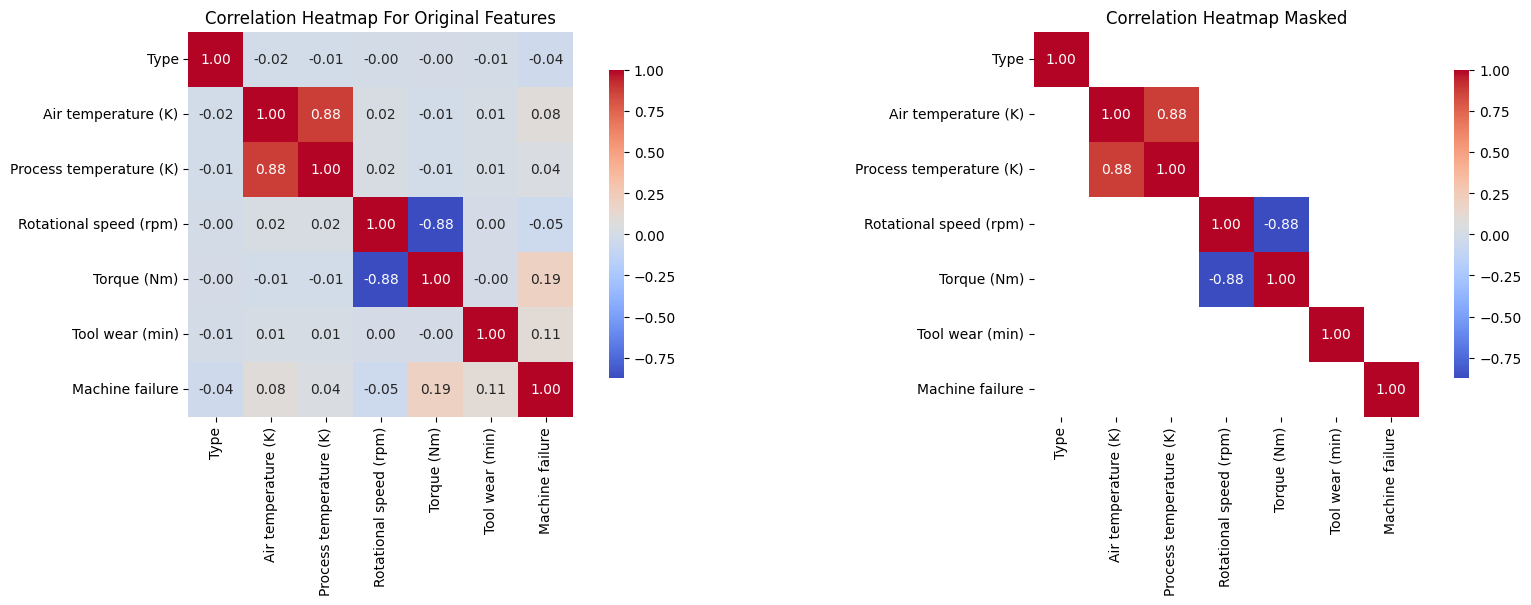

In [15]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.heatmap(dfc_cor_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap For Original Features')
plt.subplot(1,2,2)
threshold = 0.8
mask = np.abs(dfc_cor_matrix) < threshold
sns.heatmap(dfc_cor_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap Masked')
plt.show()


From the correlation heat map, we do not see many strong correlation except for :
- Process Temperature and Air Temperature
- Rotational Speed and Torque (inverse relationship)



### Correlation For Label/Failures

In [16]:
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
features_list = list(correlation_matrix_abs.loc[failure_columns, 'Machine failure'].items())
features_list.sort(key=lambda x: x[1], reverse=True)
print("- Machine failure correlation:")
for feature, value in features_list:
    if value >= 0.05:
        print(f" - {feature:30} {value:.2f}")

- Machine failure correlation:
 - HDF                            0.57
 - OSF                            0.52
 - PWF                            0.52
 - TWF                            0.36
 - RNF                            0.23


We learned that Machine Failure is mostly caused by HDF, OSF and PWF 

TWF and RNF still contribute to Machine Failure but in lesser impact

In [17]:
for col in failure_columns:
    features_list = list(correlation_matrix_abs.loc[non_failure_columns, col].items())
    features_list.sort(key=lambda x: x[1], reverse=True)
    print(f"- {col}:")
    for feature, value in features_list:
        if value >= 0.1:
            print(f"\t- {feature:30} {value:.2f}")

- TWF:
	- Tool wear (min)                0.12
- HDF:
	- Temperature Difference (K)     0.19
	- Torque (Nm)                    0.14
	- Air temperature (K)            0.14
	- Rotational speed (rpm)         0.12
	- Power (W)                      0.12
- PWF:
	- Rotational speed (rpm)         0.12
- OSF:
	- Strain (minNm)                 0.27
	- Torque (Nm)                    0.18
	- Power (W)                      0.18
	- Tool wear (min)                0.16
	- Rotational speed (rpm)         0.10
- RNF:


We learned  each failures' correlations in descending order:
- TWF:
	- Tool wear (min)                0.12
- HDF:
	- Temperature Difference (K)     0.19
	- Torque (Nm)                    0.14
	- Air temperature (K)            0.14
	- Rotational speed (rpm)         0.12
	- Power (W)                      0.12
- PWF:
	- Rotational speed (rpm)         0.12
- OSF:
	- Strain (minNm)                 0.27
	- Torque (Nm)                    0.18
	- Power (W)                      0.18
	- Tool wear (min)                0.16
	- Rotational speed (rpm)         0.10
- RNF:

## Save Data

In [18]:
df.to_csv('data/ai4i2020_cleaned.csv', index=False)

## Split Data to Training and Test Data

In [19]:
labels = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
X = df.drop(columns=labels)
y = df[labels]
print(f"shape of X {X.shape}, shape of y {y.shape}")
print(f"X columns {X.columns}")
print(f"y columns {y.columns}")

shape of X (10000, 9), shape of y (10000, 6)
X columns Index(['Type', 'Air temperature (K)', 'Process temperature (K)',
       'Rotational speed (rpm)', 'Torque (Nm)', 'Tool wear (min)',
       'Strain (minNm)', 'Power (W)', 'Temperature Difference (K)'],
      dtype='object')
y columns Index(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], dtype='object')


In [20]:
# Split the data into training and test sets
# We will use stratified sampling to ensure that the distribution of the target variable is preserved in both sets.
# This is important for imbalanced datasets.
# We will use a random state of 42 for reproducibility.
# We will also use a test size of 20% and a train size of 80%.  
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,  stratify=y['Machine failure']) 
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)


In [21]:
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

## Feature Selection

We already know that with the introduction of new features, some features are already encapsulated in our new features. 

Hence, let's create simplified dataset for both oversampled and original datasets with these features removed.

Let's revisit correlation study again for Machine failure

In [22]:
print("Machine failure correlation with non-failure features:")
features_list = list(correlation_matrix_abs.loc[non_failure_columns, 'Machine failure'].items())
features_list.sort(key=lambda x: x[1], reverse=True)
for feature, value in features_list:
    print(f" - {feature:30} {value:.2f}")

Machine failure correlation with non-failure features:
 - Torque (Nm)                    0.19
 - Strain (minNm)                 0.19
 - Power (W)                      0.18
 - Temperature Difference (K)     0.11
 - Tool wear (min)                0.11
 - Air temperature (K)            0.08
 - Rotational speed (rpm)         0.05
 - Process temperature (K)        0.04
 - Type                           0.04


Based on our insight from data documentation and confirmed by the correlation above,
we should keep:
 - Strain (minNm)                 
 - Power (W)                      
 - Tool wear (min)                
 - Rotational speed (rpm)         
 - Type

 We could remove the following features that is already encapsulated in the new features:
 - Torque (Nm)
 - Process temperature (K)
 - Air temperature (K)

In [23]:
redudant_features = ['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)']
X_train_reduced = X_train.drop(columns=redudant_features)
X_test_reduced = X_test.drop(columns=redudant_features)

In [24]:
X_train_reduced.columns

Index(['Type', 'Rotational speed (rpm)', 'Tool wear (min)', 'Strain (minNm)',
       'Power (W)', 'Temperature Difference (K)'],
      dtype='object')

In [25]:
df[['Type', 'Rotational speed (rpm)', 'Tool wear (min)', 'Strain (minNm)', 'Process temperature (K)', 'Air temperature (K)']].describe()

,Type,Rotational speed (rpm),Tool wear (min),Strain (minNm),Process temperature (K),Air temperature (K)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.500300,1538.776100,107.951000,4314.664550,310.005560,300.004930
std,0.671301,179.284096,63.654147,2826.567692,1.483734,2.000259
min,0.000000,1168.000000,0.000000,0.000000,305.700000,295.300000
25%,0.000000,1423.000000,53.000000,1963.650000,308.800000,298.300000
50%,0.000000,1503.000000,108.000000,4012.950000,310.100000,300.100000
75%,1.000000,1612.000000,162.000000,6279.000000,311.100000,301.500000
max,2.000000,2886.000000,253.000000,16497.000000,313.800000,304.500000


In [26]:
import json
spec = {
    "Type":{"max":2,"min":0,"dtype":"int"},
    "Rotational speed (rpm)":{"max":2886.0,"min":1168.0,"dtype":"float"},
    "Tool wear (min)":{"max":253,"min":0,"dtype":"float"},
    "Torque (Nm)":{"max":76.6,"min":3.8,"dtype":"float"},
    "Process temperature (K)":{"max":313.8,"min":305.7,"dtype":"float"},
    "Air temperature (K)":{"max":304.5,"min":295.3,"dtype":"float"}
}
with open("spec.json","w") as f:
    json.dump(spec,f)